
# Redes Convolucionales Sep-Dic 2023
---
Raúl Guaidó 16-10486

CIFAR-100 es un conjunto de datos utilizado para el reconocimiento de objetos en imágenes. Al igual que MNIST, es uno de los conjuntos de datos más ampliamente utilizados por investigadores, ingenieros, practicantes y aficionados a la visión computarizada y machine learning.

CIFAR son las siglas del Canadian Institute for Advanced Research, donde Alex Krizhevsky, Vinod Nair y uno de los padres de la Inteligencia Artificial, Geoffrey Hinton, recopilaron un subconjunto del conjunto de datos 80 million tiny images.

Éstas son las características generales de CIFAR-100:

*   Tener dos tipos de etiquetas (las cuales puedes consultar aquí).
*   20 superclases (referidas como coarse, en inglés).
*   100 subclases (referidas como fine, en inglés).
*   600 imágenes por cada una de las 100 subclases.
*   50.000 imágenes de entrenamiento y 10.000 de prueba.
*   Imágenes de 32×32 en espacio RGB.

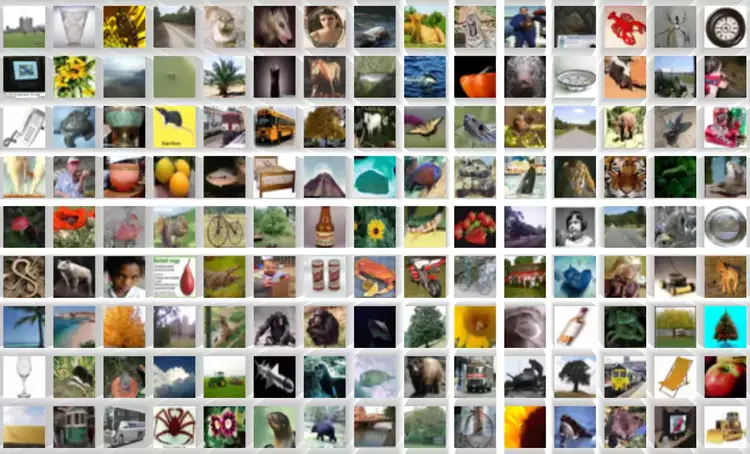

Para el modelo de la red convolucional se usara pytorch, esta libreria contiene todas las dependencias necesarias para el aprendizaje automatico, es ampliamente utilizado para aplicaciones de vision artificial y procesamiento de lenguaje natural, a parte nos permitira descargar el dataset y normalizarlo para poder usarlo como entrenamiento y test a la red.

Se utilizaran las librerias matplotlib y su extension matematica numpy para visualizar las imagenes y plotear lo deseado.

In [2]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import sampler
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import  f1_score, accuracy_score, confusion_matrix
from google.colab import drive

Configuracion del DRive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/CNN_Proyecto_Final
%ls

[Errno 2] No such file or directory: '/content/drive/MyDrive/CNN_Proyecto_Final'
/content
drive/  sample_data/


Como se menciono, se usara el dataset CIFAR-100. Para descargarla se usa el metodo datasets de pytorch y para trasformar las imagenes a tensores y normalizarlos se usa el metodo transform igual de pytorch.

In [7]:
transform = transforms.Compose(
    [ToTensor(),
     transforms.Normalize(mean =[0.5, 0.5, 0.5], std =[0.22, 0.22, 0.22])])

batch_size = 10

train_set = torchvision.datasets.CIFAR100(root='./data_src', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR100(root='./data_src', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4)
validation_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(10000)), num_workers=4)

classes = train_set.classes
PATH = "./DATA.pth"
train = torch.save(
                    {"train_loader": train_loader,
                     "test_loader": test_loader,
                     "validation_loader": validation_loader,
                     "classes": classes,
                     "batch_size": batch_size,}, PATH,
)

Files already downloaded and verified
Files already downloaded and verified


A continuacion podemos visualizar 5 imagenes aleatorias del dataset de entrenamiento, las cuales estan identificadas con su clase.

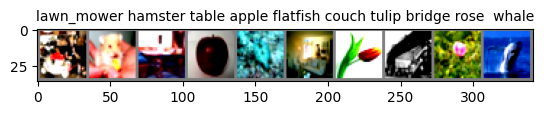

In [8]:
def imagenshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)), fontsize=10)
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imagenshow(torchvision.utils.make_grid(images,nrow=10))

Se usara la GPU en caso de estar disponible, se recomienda utilizarla debido a que el entrenamiento es bastante demorado y al utilizar los calculos matriciales de las GPUs es mucho mas rapido realizarlo.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Definicion de la Red Neuronal Convolucional

In [12]:
def conv(channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    ]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)



class CNN1(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = conv(3, 100)
        self.conv2 = conv(100, 150, pool=True)
        self.res1 = nn.Sequential(conv(150, 150), conv(150, 150))

        self.conv3 = conv(150, 200, pool=True)
        self.conv4 = conv(200, 300, pool=True)
        self.res2 = nn.Sequential(conv(300, 300), conv(300, 300))

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(300, 100))



    def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.res1(x) + x
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.res2(x) + x
      x = self.classifier(x)
      return x


Resnet = CNN1()
Resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Resnet.parameters(), lr=0.005, momentum=0.80)

In [14]:
PATH = "./DATA.pth"
dataset = torch.load(PATH)
print(dataset)

{'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a54cb145360>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a54cb1461d0>, 'validation_loader': <torch.utils.data.dataloader.DataLoader object at 0x7a54cb1456f0>, 'classes': ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 's

In [15]:
array_train_loss= []
array_validation_loss= []

Nro_epocas = 30

for epoch in range(Nro_epocas):
    valid_loss = 0.0
    running_loss = 0.0
    inicio = time.time()

    for inputs, labels in dataset["train_loader"]:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = Resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    Resnet.eval()

    for inputs, labels in dataset["validation_loader"]:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = Resnet(inputs)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()

    running_loss = running_loss /len(train_loader)
    print(print("\n[Epoca", epoch + 1, "] \nloss:", running_loss))


    valid_loss = valid_loss / len(validation_loader)
    print("\n val_loss:", valid_loss)

    array_train_loss.append(running_loss)
    array_validation_loss.append(valid_loss)

    fin = time.time()
    duracion = fin - inicio
    print(epoch+1, duracion, "segundos.")

print('Entrenamiento finalizado')


[Epoca 1 ] 
loss: 4.136370042896271
None

 val_loss: 3.512295915365219
1 62.911619663238525 segundos.

[Epoca 2 ] 
loss: 2.8559392531871794
None

 val_loss: 2.3058276823163033
2 60.53763556480408 segundos.

[Epoca 3 ] 
loss: 2.1516257404625416
None

 val_loss: 1.7784943307638168
3 61.649821758270264 segundos.

[Epoca 4 ] 
loss: 1.7460025465130806
None

 val_loss: 1.4158825863301754
4 60.38441729545593 segundos.

[Epoca 5 ] 
loss: 1.4419814459010958
None

 val_loss: 1.1363709104508162
5 60.150667905807495 segundos.

[Epoca 6 ] 
loss: 1.1845046360731124
None

 val_loss: 0.8599370715096593
6 60.620742082595825 segundos.

[Epoca 7 ] 
loss: 0.9484495078384876
None

 val_loss: 0.7048104770630598
7 60.707624673843384 segundos.

[Epoca 8 ] 
loss: 0.7488802767328918
None

 val_loss: 0.47186760541237893
8 62.9256010055542 segundos.

[Epoca 9 ] 
loss: 0.5839634919246659
None

 val_loss: 0.42349491304531695
9 60.49091553688049 segundos.

[Epoca 10 ] 
loss: 0.46214299841625617
None

 val_loss: 0.3

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


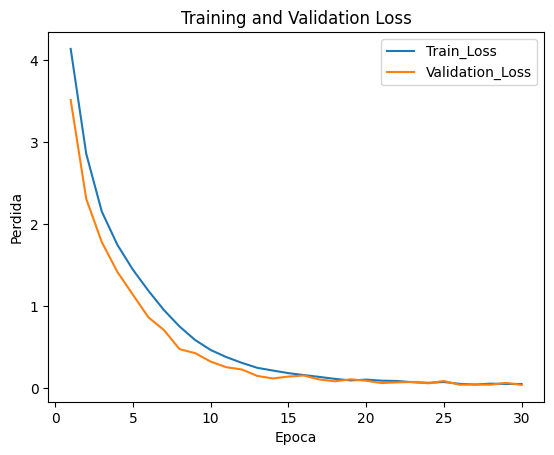

In [16]:
epocas = list(range(1, epoch+2))
print(epocas)

plt.plot(epocas, array_train_loss , label="Train_Loss")
plt.plot(epocas, array_validation_loss , label="Validation_Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoca")
plt.ylabel("Perdida")
plt.legend()

# Carga del modelo entrenado en la carpeta 'Training_Model.pt'

In [17]:
PATH = './Training_Model.pt'
torch.save({
            'epoch': epoch,
            'model_state_dict': Resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
            }, PATH)


# Calculo de la precision del modelo ya entrenado
A continuacion se muestra la precision de la red a nivel general

In [18]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
        outputs = Resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Precision de la CNN en la prueba de 10000 imagenes:{100 * correct // total} %')

Precision de la CNN en la prueba de 10000 imagenes:54 %


Seguidamente se muestra el calculo de la preciocion por clases, esto nos permite ver que la red tiene un alto porcentaje correcto de prediccion.

In [19]:
class_name = train_set.classes

correct_predictions = [0] * len(class_name)
total_images = [0] * len(class_name)

for images, labels in dataset["test_loader"]:
    if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()
    outputs = Resnet(images)
    _, predicted = torch.max(outputs.data, 1)
    for i in range(len(labels)):
        label = labels[i]
        prediction = predicted[i]
        if label == prediction:
          correct_predictions[label] += 1
        total_images[label] += 1


    running_loss = running_loss /len(train_loader)

class_accuracy = [100*correct_predictions[i] / total_images[i] for i in range(len(class_name))]


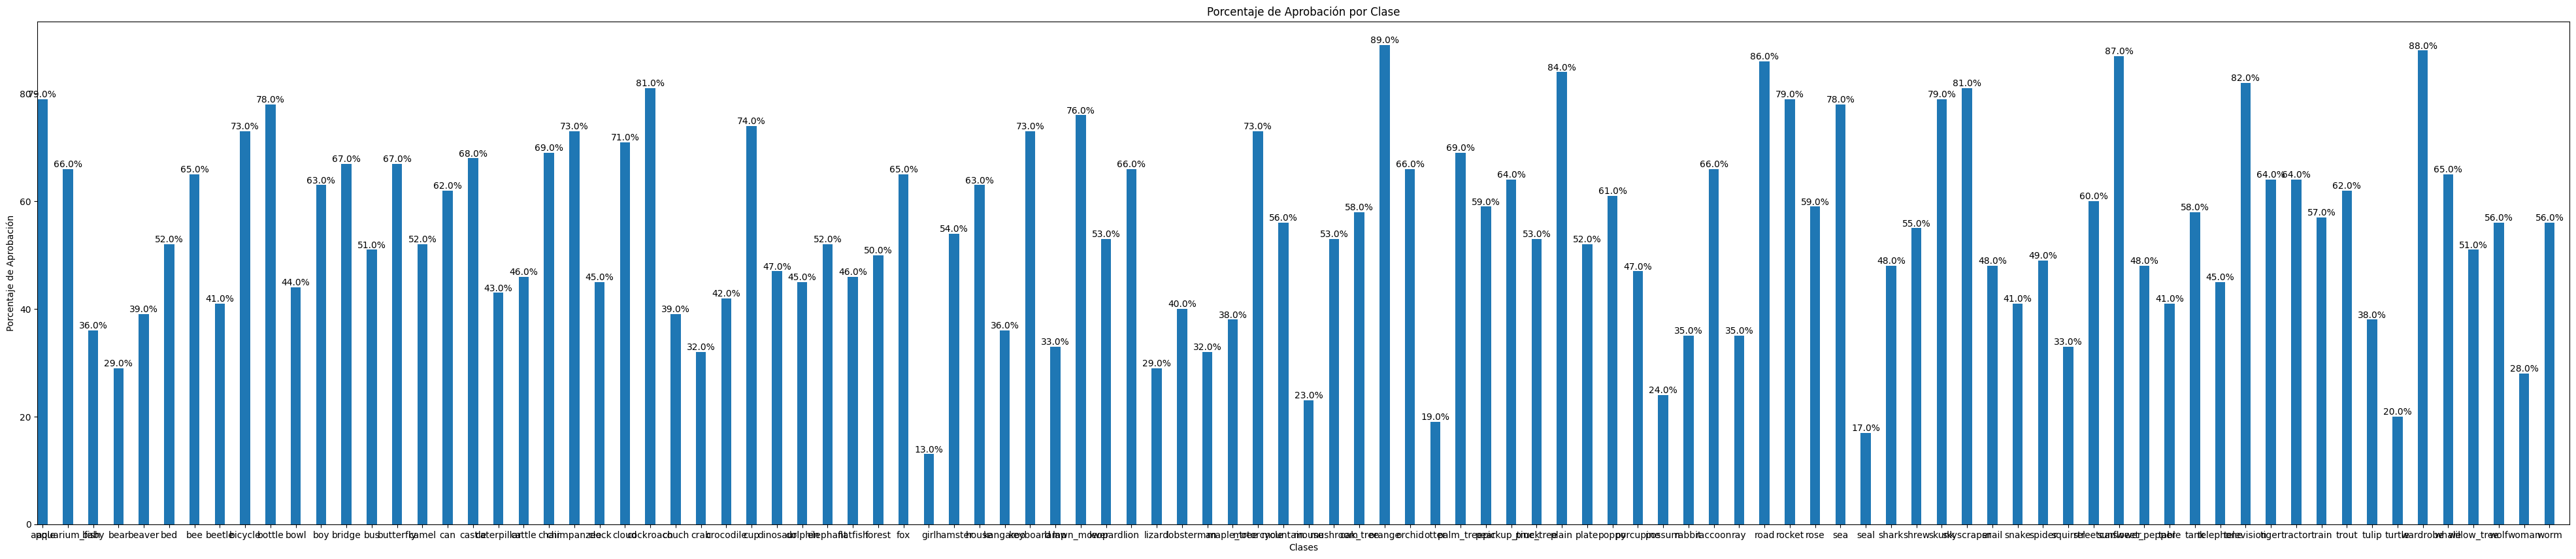

In [24]:
plt.figure(figsize=(30, 6))
bar_width = 0.4
bar_spacing = 0.2
plt.bar(np.arange(len(class_name)), class_accuracy, width = bar_width)
plt.xticks(np.arange(len(class_name)), class_name)
plt.xlabel('Clases')
plt.ylabel('Porcentaje de Aprobación')
plt.title('Porcentaje de Aprobación por Clase')
for i, v in enumerate(class_accuracy):
    plt.text(i, v, str(v) + '%', ha='center', va='bottom')

plt.xlim(-bar_spacing, len(class_name) - bar_spacing)
plt.show()

# Mapa de Calor
Para la primera capa convolucional el mapa de calor nos permite visualizar cuales son las regiones de activacion mas importantes, observando que es bastante aleatorio como es de esperarse.

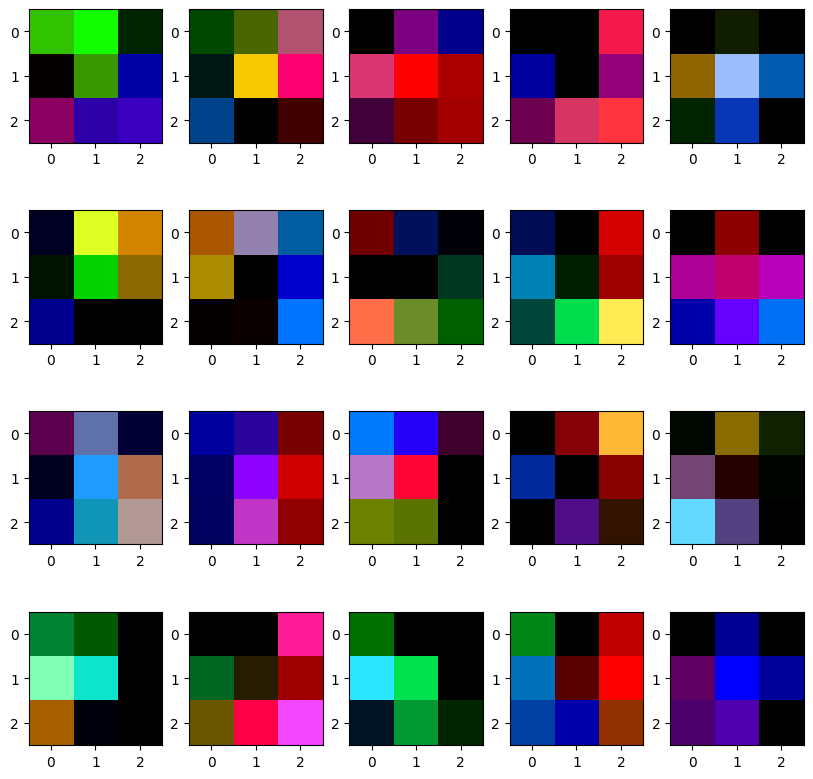

In [21]:
weight1 = []

for x in Resnet.state_dict()['conv1.0.weight'].cpu():
      w1 = np.transpose(x)
      w1 = w1/w1.max()
      w1 = np.clip(w1, 0, 1)
      weight1.append(w1)

figure, axes = plt.subplots(nrows=4, ncols=5, figsize =(10,10))

for a, b in zip(axes.ravel(), range(20)):
  nimage = np.random.randint(len(weight1))
  a.imshow(weight1[b])


Para la segunda capa se observan zonas mas intensas lo que nos muestra cuales son los pixeles que mas toma en consideracion la red para tomar la decision de la prediccion en funcion a la imagen que se esta prediciendo.

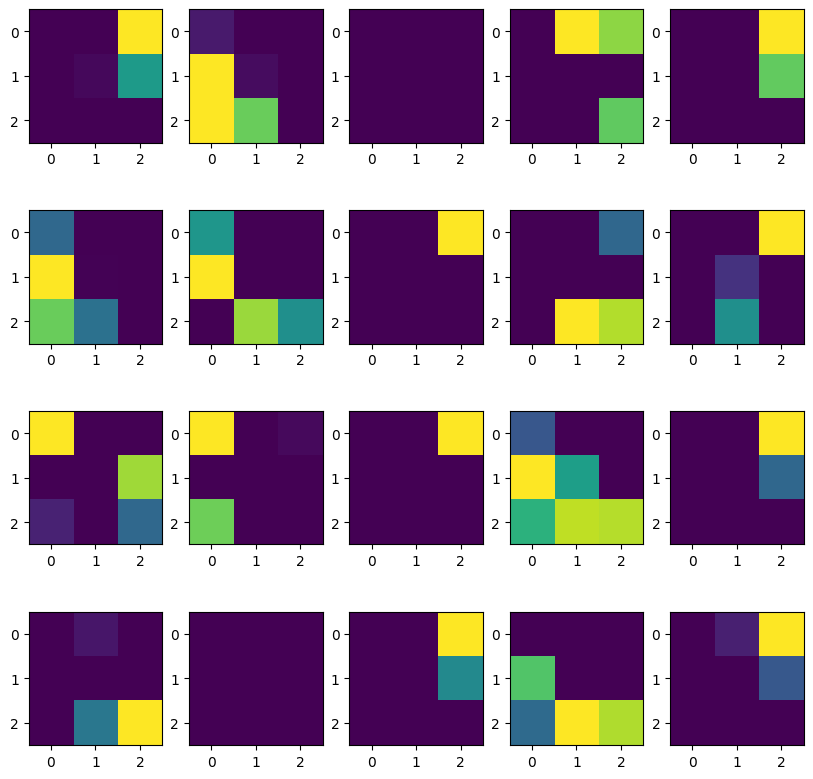

In [22]:
weight2 = []
for x in Resnet.state_dict()['conv2.0.weight'].cpu():
  for w in x:
      w2 = w
      w2 = w2/w2.max()
      w2 = np.clip(w2, 0, 1)
      weight2.append(w2)

figure, axes = plt.subplots(nrows=4, ncols=5, figsize =(10,10))

for a, b in zip(axes.ravel(), range(30)):
  nimage = np.random.randint(len(weight2))
  a.imshow(weight2[b])

# Conclusiones
Al entrenar el modelo, se logro una mejora de este de un 15% inicialmente a un 54%, esto al realizar cambios en la arquitectura de la red. Al aumentar el numero de canales internos de la red y cambiar de ReLU a SeLU, nos permitio realizar una mejora considerable al modelo.

Se puede observar que la precision por clases es bastante buena para la mayoria de estas. Esto podria mejorarse al introducir mas capas convolucionales a la red.
